# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек

In [1]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
import statsmodels.stats.power as power

In [3]:
df = pd.read_excel('AB_Test_Results.xlsx')

In [4]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [7]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [8]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [9]:
#Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [10]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [11]:
more_than_one_types = v.query('VARIANT_NAME > 1')

In [12]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [13]:
df_new.shape

(6070, 3)

In [14]:
df.shape

(10000, 3)

In [15]:
control = df.query('VARIANT_NAME == "control"')

test = df.query('VARIANT_NAME == "variant"')

In [16]:
len(control)

4984

In [17]:
len(test)

5016

### Проверка на нормальность

In [18]:
alpha = 0.05

sh = st.shapiro(df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[sh[1] < alpha]));

Distribution is not normal



#### Постороим график дохода на юзера по группам

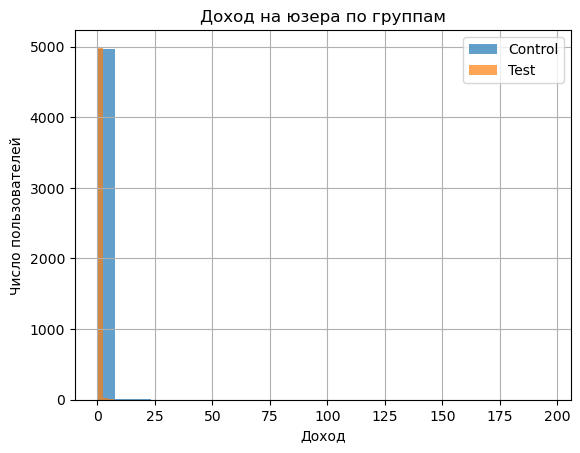

In [19]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

In [20]:
mw_stats = st.mannwhitneyu(x=control.REVENUE.values, y = test.REVENUE.values)

mw_stats

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)

Построим Боксплот по пользователям

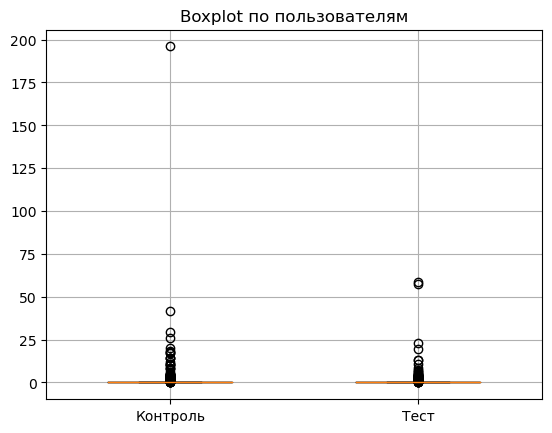

In [21]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [22]:
st.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.268403803110966, pvalue=0.20469713432410777)

## Расчет мощности теста 


d = (M1 – M2) / S_pooled






## S_pooled =

  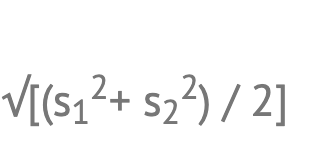

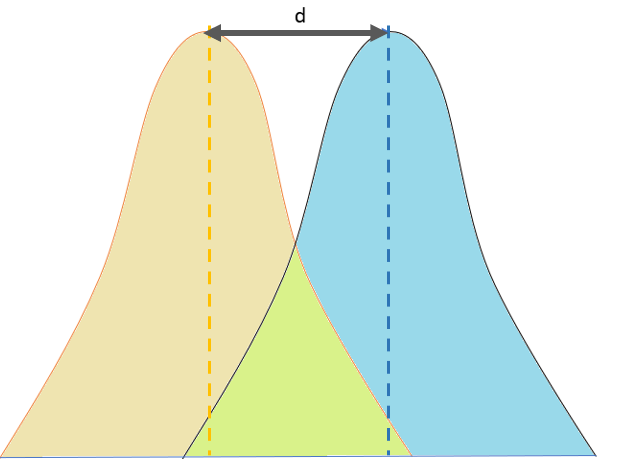

In [23]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [24]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

4984 5016


In [25]:
n =  len(control.REVENUE.values)

In [26]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [27]:
ef =float((T_mean-C_mean)/ S)

In [28]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = power.TTestIndPower()
result = analysis.solve_power(ef, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result

0.24502831099016653

### Ответ:
Статистически значимой разницы между группами нет. Но при полученных значениях мощности правильное заключение вынести не представляется возможным. 
Я бы рекомендовал менеджеру не применять измененный вариант на всех пользователях, либо провести тест повторно